# Orbit Fitting & Jupiter Mass Estimation

This notebook models the orbital motion of Jupiter’s Galilean moons based on image-derived position data. It performs the following steps:

- Converts observed pixel coordinates into physical distances using telescope parameters and Earth–Jupiter distance
- Fits sinusoidal models to moon orbits to extract amplitude, frequency, and phase
- Calculates orbital periods and applies Kepler’s Third Law to estimate Jupiter’s mass
- Propagates uncertainties in fit parameters to compute mass errors
- Compares results with known literature values

This workflow demonstrates the use of curve fitting, error analysis, and physical modeling to derive planetary properties from raw observational data.


### Define moon positions and metadata for each observation

This block creates a DataFrame containing timestamps, Earth–Jupiter distances (in AU), and pixel coordinates of Jupiter and its moons for 15 observation frames. The moon coordinates also include a flag indicating whether the moon appears to the left of Jupiter in the image.


In [1]:
import pandas as pd
from datetime import datetime
import math
import numpy as np

# Creating a list of Python datetime objects
date_objects = [datetime(2024, 1, 8, 22, 3, 0),
                datetime(2024, 1, 9, 20, 33, 0),
                datetime(2024, 1, 9, 22, 9, 0),
                datetime(2024, 1, 10, 00, 40, 0),
                datetime(2024, 1, 10, 17, 37, 0),
                datetime(2024, 1, 10, 18, 53, 0),
                datetime(2024, 1, 10, 21, 15, 0),
                datetime(2024, 1, 10, 22, 16, 0),
                datetime(2024, 1, 10, 23, 16, 0),
                datetime(2024, 1, 11, 0, 38, 0),
                datetime(2024, 1, 11, 17, 32, 0),
                datetime(2024, 1, 11, 18, 34, 0),
                datetime(2024, 1, 11, 20, 55, 0),
                datetime(2024, 1, 11, 22, 18, 0),
                datetime(2024, 1, 11, 23, 44, 0)]


# Creating the DataFrame with datetime objects and columns for each moon
# 'moon': [x,y,left?] 3rd entry to specify if moon is to the left of jupiter
data = {'DateTimeColumn': date_objects,
        'earth-jupiter[AU]': [4.60, 4.61, 4.61, 4.62, 4.63, 4.63, 4.63, 4.63, 4.63, 4.63, 4.64, 4.64, 4.65, 4.65, 4.65],
        'jupiter': [[186.7650980342755, 383.38562666394245],[168.38231881353647, 442.0989214728712],[509.248518961985, 572.247732917386],[306.31538444, 365.37961369],[446.7121034666127, 398.79980308346927],[189.4272876739478, 439.83088103062187],[215.78432164963144, 647.6638697957267],[106.38271360753816, 261.8760669229043],[197.60393690548307, 212.22579195413977],[89.9277475332702, 279.3279518572822],[278.2901198576503, 260.6543451854493],[266.9186485994262, 243.70037930339453],[489.88286379948113, 888.987412774892],[712.0372102612438, 734.7192198276412],[518.4172970623148, 823.2803559521006]],
        'Io': [[143.73192334, 298.01791449,1],[206.92264759, 568.51270009, 0],[573.11577298, 731.09353163, 0],[408.21828146, 543.16526979, 0],[349.81802872, 490.29646536, 1],[100.57995647, 577.52587913, 1], [118.90110753, 455.09475824, 1],[94.59425078, 31.10813124, 1],[28.07102292, 46.08276635, 1],[109.88710664, 40.30713002, 1],[145.06367385, 115.71212703, 0],[117.89584915, 87.65263691, 0],[662.32067537, 1054.8592099, 0],[788.37495865, 962.75924027, 0],[592.19867574, 1039.08948861, 0]],
        'Europa': [[143.73192334, 298.01791449,1],[30.18979662, 107.2175673, 1],[ 357.13270253, 258.95655641, 1],[131.26688373, 92.57224423, 1],[539.63070479, 333.06863947, 0],[277.7839677, 322.96270161, 0],[298.41655325, 832.86027759, 0],[109.27525615, 485.8711136, 0],[367.7497046, 391.23477565, 0],[55.88138345, 550.4916745, 0],[31.43749392,  34.20029788, 0],[28.22437703, 27.84363115, 0],[703.52434466, 1070.56249272, 0],[806.92810331, 969.08625984, 0],[604.65547718, 1025.24741292, 0]],
        'Ganymede': [[524.00492639, 877.11535632,0],[316.23282564, 747.21035768, 0],[660.69801462, 837.92337347, 0],[454.83230576, 555.38119396, 0],[349.81802872, 490.29646536, 1],[ 94.73204091, 541.62212385, 1],[154.35555768, 466.82613835, 1],[122.47997484, 49.12490503, 1],[53.00945966, 31.07088126, 1],[140.90277772, 26.43519593, 1],[660.31941999, 647.87037436, 1],[653.77582138, 641.48815187, 1],[84.24939286, 476.62650152, 1],[548.30509028, 170.80759865, 1],[352.25111151, 251.48859088, 1]],
        'Callisto': [[748.90486916, 1173.33802204,0],[479.20044506, 1132.32750915, 0],[844.47254813, 1222.34144584, 0],[692.42082775, 937.11394436, 0],[731.04272563, 28.9159741, 0],[370.35081054, 27.32729471, 0],[455.32349872, 983.1746219, 0],[185.8868335, 649.77100576, 0],[505.68676395, 435.23126677, 0],[110.87803408, 637.77896272, 0],[185.21032093, 236.87674356, 0],[184.22694382, 232.32055615, 0],[520.11739134, 890.05662166, 0],[712.0372102612438, 734.7192198276412, 0],[566, 777, 1]],}

df = pd.DataFrame(data)

# Displaying the DataFrame
print(df)

        DateTimeColumn  earth-jupiter[AU]  \
0  2024-01-08 22:03:00               4.60   
1  2024-01-09 20:33:00               4.61   
2  2024-01-09 22:09:00               4.61   
3  2024-01-10 00:40:00               4.62   
4  2024-01-10 17:37:00               4.63   
5  2024-01-10 18:53:00               4.63   
6  2024-01-10 21:15:00               4.63   
7  2024-01-10 22:16:00               4.63   
8  2024-01-10 23:16:00               4.63   
9  2024-01-11 00:38:00               4.63   
10 2024-01-11 17:32:00               4.64   
11 2024-01-11 18:34:00               4.64   
12 2024-01-11 20:55:00               4.65   
13 2024-01-11 22:18:00               4.65   
14 2024-01-11 23:44:00               4.65   

                                     jupiter  \
0    [186.7650980342755, 383.38562666394245]   
1    [168.38231881353647, 442.0989214728712]   
2       [509.248518961985, 572.247732917386]   
3               [306.31538444, 365.37961369]   
4    [446.7121034666127, 398.7998030834

### Compute signed pixel distances between moons and Jupiter

This block calculates the relative pixel distance of each moon from Jupiter for every observation. Distances are signed based on whether the moon appears to the left or right of Jupiter, enabling sinusoidal orbit fitting later.


In [2]:
# Create a new DataFrame to store distances
distances_data = {'DateTimeColumn': date_objects,
                  'Io': np.zeros_like(date_objects),
                  'Europa': np.zeros_like(date_objects),
                  'Ganymede': np.zeros_like(date_objects),
                  'Callisto': np.zeros_like(date_objects)}

# for-loop to compute relative distances to jupiter
for moon in ['Io', 'Europa', 'Ganymede', 'Callisto']:
    pixel_distances = []
    for i in range(len(df)):
        jupiter_pos = np.array(df['jupiter'][i])
        moon_pos = df[moon][i][0:2]
        sign = df[moon][i][2]
        rel_pos = moon_pos - jupiter_pos
        pixel_distance = np.linalg.norm(rel_pos)
        if sign == 1: pixel_distance = -pixel_distance
        pixel_distances.append(pixel_distance)
    distances_data[moon] = pixel_distances
print(pd.DataFrame(distances_data))
distances_data['Io'][0]

        DateTimeColumn          Io      Europa    Ganymede    Callisto
0  2024-01-08 22:03:00  -95.600734  -95.600734  597.912826  969.549333
1  2024-01-09 20:33:00  132.158240 -362.274336  339.046842  756.983098
2  2024-01-09 22:09:00  171.204597 -348.267976  305.811209  731.434881
3  2024-01-10 00:40:00  204.919350 -324.138610  241.159442  689.896774
4  2024-01-10 17:37:00 -133.267029  113.817628 -133.267029  466.538262
5  2024-01-10 18:53:00 -163.871171  146.509639 -139.027504  450.435933
6  2024-01-10 21:15:00 -215.567205  202.794958 -190.986330  412.245658
7  2024-01-10 22:16:00 -231.068838  224.013722 -213.359271  395.958822
8  2024-01-10 23:16:00 -237.370836  246.969226 -231.785816  380.324165
9  2024-01-11 00:38:00 -239.852724  273.292736 -257.979068  359.062727
10 2024-01-11 17:32:00  196.869329  334.989036 -543.950953   96.068847
11 2024-01-11 18:34:00  215.774634  321.821520 -554.881595   83.471063
12 2024-01-11 20:55:00  239.266069  280.378658 -578.428936   30.253427
13 202

-95.60073433860805

### Convert pixel distances to physical distances in kilometers

This block defines a function to convert pixel distances into absolute distances (km) using the telescope's pixel scale and Earth–Jupiter distance. It then applies this to all moon observations to create a new DataFrame with real orbital distances.


In [3]:
def pixel_to_absolute(pixel_distance, jupiter_distance):
    pixel_size = 6.54
    focal_length = 2800
    arcsec_per_pixel = pixel_size / focal_length * 206.2648
    radians_per_pixel = arcsec_per_pixel/3600/180*math.pi
    jupiter_distance_km = jupiter_distance * 1.496e8
    abs_distance = jupiter_distance_km*math.sin(radians_per_pixel*pixel_distance)
    return abs_distance

# Create a new DataFrame to store distances
absolute_data = {'DateTimeColumn': date_objects,
                  'Io': np.zeros_like(date_objects),
                  'Europa': np.zeros_like(date_objects),
                  'Ganymede': np.zeros_like(date_objects),
                  'Callisto': np.zeros_like(date_objects)}

# for-loop to convert from pixel to km
for moon in ['Io', 'Europa', 'Ganymede', 'Callisto']:
    absolute_distances = []
    for i in range(len(df)):
        absolute_distance = pixel_to_absolute(distances_data[moon][i], df['earth-jupiter[AU]'][i])
        absolute_distances.append(absolute_distance)
    absolute_data[moon] = absolute_distances
absolute_df = pd.DataFrame(absolute_data)
absolute_df

    

,DateTimeColumn,Io,Europa,Ganymede,Callisto
0,2024-01-08 22:03:00,-153663.370062,-153663.370062,961051.935593,1.558399e+06
1,2024-01-09 20:33:00,212885.686218,-583565.676459,546149.927758,1.219378e+06
2,2024-01-09 22:09:00,275783.089105,-561003.688176,492612.679315,1.178223e+06
3,2024-01-10 00:40:00,330808.169076,-523267.783193,389311.757658,1.113723e+06
4,2024-01-10 17:37:00,-215603.097591,184137.317492,-215603.097591,7.547784e+05
5,2024-01-10 18:53:00,-265115.326630,237027.359027,-224922.554177,7.287276e+05
6,2024-01-10 21:15:00,-348750.597998,328087.305015,-308982.979565,6.669424e+05
7,2024-01-10 22:16:00,-373829.567313,362415.606260,-345178.542065,6.405931e+05
8,2024-01-10 23:16:00,-384025.113201,399553.652092,-374989.513786,6.152989e+05
9,2024-01-11 00:38:00,-388040.379857,442140.549740,-417365.678057,5.809016e+05


In [4]:
time_list = []
for timestamp in absolute_df.DateTimeColumn:
    time_list.append(timestamp.timestamp())

### Plot absolute moon distances over time

This block visualizes the absolute distance of each Galilean moon from Jupiter as a function of time. Each moon is shown in its own subplot to highlight its orbital motion.

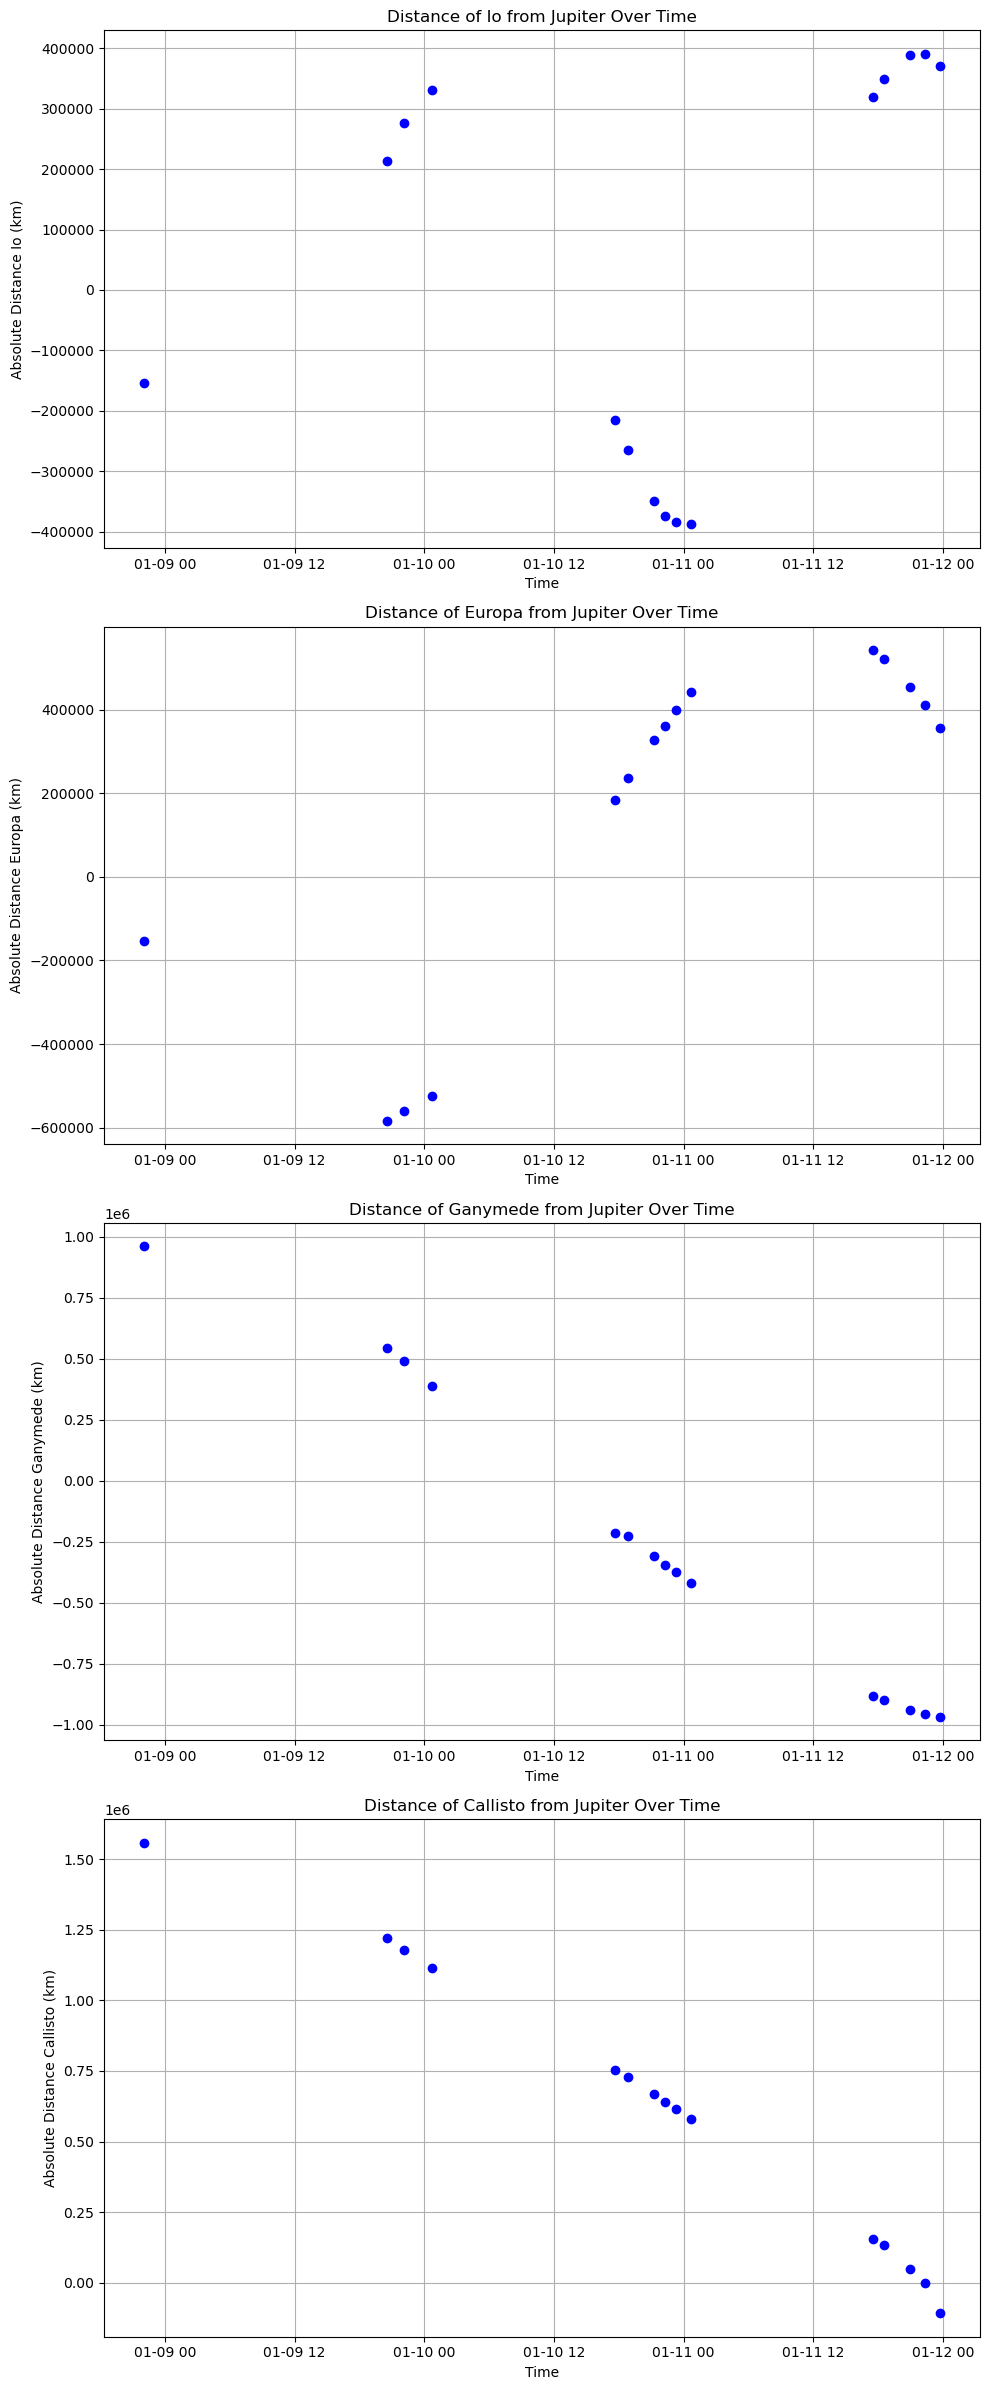

In [5]:
import matplotlib.pyplot as plt


# Plotting the distance against time for each moon on separate graphs
moon_list = ['Io', 'Europa', 'Ganymede', 'Callisto']
fig, axes = plt.subplots(nrows=len(moon_list), ncols=1, figsize=(10, 6 * len(moon_list)))

for i, moon in enumerate(moon_list):
    axes[i].plot(absolute_df['DateTimeColumn'], absolute_df[moon], "bo")
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel(f'Absolute Distance {moon} (km)')
    axes[i].set_title(f'Distance of {moon} from Jupiter Over Time')
    axes[i].grid()

plt.tight_layout()
plt.show()


In [6]:
# Add a new 'Days' column for the conversion of DateTimeColumn to days
absolute_df.insert(1, 'Days', (absolute_df['DateTimeColumn'] - absolute_df['DateTimeColumn'].min()).dt.total_seconds()/ (24 * 3600) )
print(absolute_df)

        DateTimeColumn      Days             Io         Europa       Ganymede  \
0  2024-01-08 22:03:00  0.000000 -153663.370062 -153663.370062  961051.935593   
1  2024-01-09 20:33:00  0.937500  212885.686218 -583565.676459  546149.927758   
2  2024-01-09 22:09:00  1.004167  275783.089105 -561003.688176  492612.679315   
3  2024-01-10 00:40:00  1.109028  330808.169076 -523267.783193  389311.757658   
4  2024-01-10 17:37:00  1.815278 -215603.097591  184137.317492 -215603.097591   
5  2024-01-10 18:53:00  1.868056 -265115.326630  237027.359027 -224922.554177   
6  2024-01-10 21:15:00  1.966667 -348750.597998  328087.305015 -308982.979565   
7  2024-01-10 22:16:00  2.009028 -373829.567313  362415.606260 -345178.542065   
8  2024-01-10 23:16:00  2.050694 -384025.113201  399553.652092 -374989.513786   
9  2024-01-11 00:38:00  2.107639 -388040.379857  442140.549740 -417365.678057   
10 2024-01-11 17:32:00  2.811806  319188.563821  543125.041665 -881919.414334   
11 2024-01-11 18:34:00  2.85

### Fit sinusoidal model to moon orbits and compare with literature

This block fits a sinusoidal model to the moons' absolute distance data using `curve_fit`. It estimates orbital parameters (amplitude, frequency, phase), compares the result to literature values by aligning phases, and plots both the fitted and reference curves. Results with uncertainties are printed and saved.


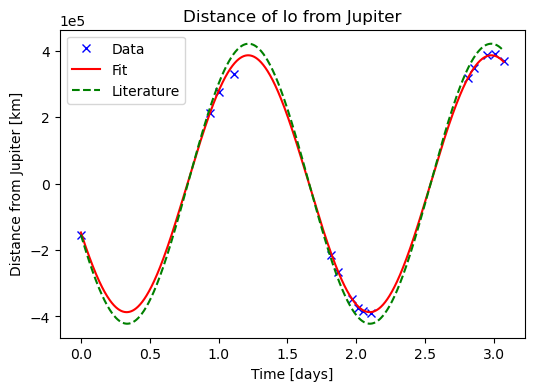

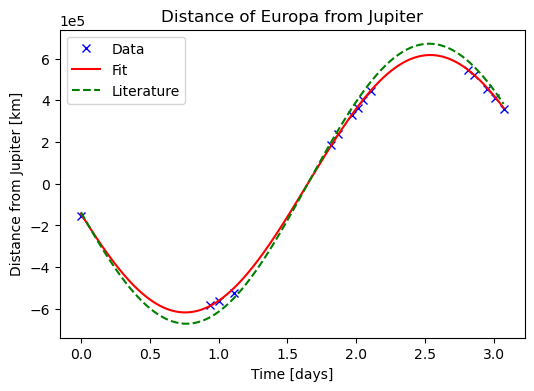

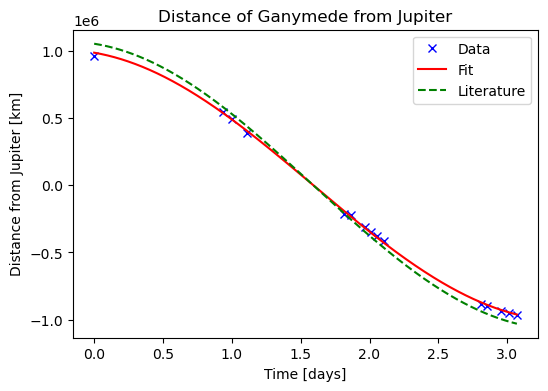

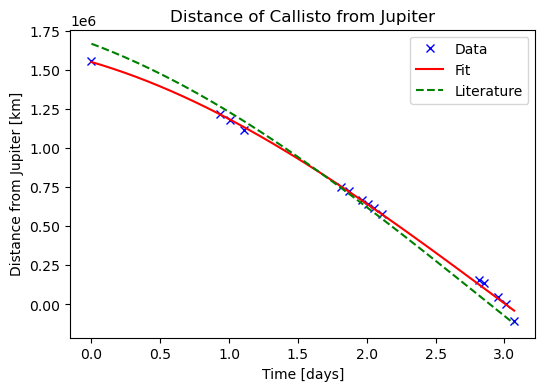

Fit Results for Io:
Amplitude (A): -386959.7324322065
Frequency (B): 3.5585236798022906
Phase (C): 0.38931719833425654
Amplitude (A)_err: 3690.8091512957244
Frequency (B)_err: 0.013272281893374255
Phase (C)_err: 0.022608907216664552


Fit Results for Europa:
Amplitude (A): -616931.607712396
Frequency (B): 1.765149315456771
Phase (C): 0.23450195990839862
Amplitude (A)_err: 3063.5034775219733
Frequency (B)_err: 0.0052041105952506375
Phase (C)_err: 0.010915138226901063


Fit Results for Ganymede:
Amplitude (A): 1008980.5525669187
Frequency (B): 0.857078931680069
Phase (C): -4.506336468174629
Amplitude (A)_err: 16390.408939779816
Frequency (B)_err: 0.023638193976351474
Phase (C)_err: 0.03888998930840511


Fit Results for Callisto:
Amplitude (A): 1686692.7802956756
Frequency (B): -0.38840003872894646
Phase (C): 1.1689527720426665
Amplitude (A)_err: 66387.6008251827
Frequency (B)_err: 0.021554999537747723
Phase (C)_err: 0.061796799870669376


                              Io         Europa  

In [7]:
from scipy.optimize import curve_fit


# Define the modified sinusoidal function to fit (without parameter D)
def sinusoidal_function(x, A, B, C):
    return A * np.sin(B * x + C) 


# Specify manual initial guesses for each moon
initial_guesses_dict = {
    'Io': [421800, 2 * np.pi / (1.7627), 0],  # Adjust as needed
    'Europa': [671100, 2 * np.pi / (3.5255), 0],  # Adjust as needed
    'Ganymede': [1070400, 2 * np.pi / (7.1556), 0],  # Adjust as needed
    'Callisto': [1882700, 2 * np.pi / (16.690), 0]  # Adjust as needed
}

df_initial_guesses_dict = pd.DataFrame(initial_guesses_dict)

# Fit a modified sinusoidal function to each moon's data with manual initial guesses
moon_names = ['Io', 'Europa', 'Ganymede', 'Callisto']
fit_results = {}

for moon in moon_names:
    plt.figure(figsize=(6, 4))
    y = absolute_df[moon].values
    x_days = absolute_df['Days'].values
    x_days_fine = np.linspace(x_days.min(), x_days.max(), 1000)
    
    # Use curve_fit with manual initial guesses
    initial_guesses = df_initial_guesses_dict[moon]
    fit_params, covariance = curve_fit(sinusoidal_function, x_days, y, p0=initial_guesses)
    
    # Define the modified sinusoidal function to fit phase of literature curve to the fitted-curve so that they align
    def sinusoidal_function2(x, C2):
        return initial_guesses_dict[moon][0] * np.sin(initial_guesses_dict[moon][1] * x + C2) 

    # Use curve fit to find phase between fit and literature curve
    # Perform the phase fit
    fit_params1, covariance1 = curve_fit(sinusoidal_function2, x_days_fine, sinusoidal_function(x_days_fine, *fit_params))
    # Add the phase shift to the initial guesses
    #print(initial_guesses_dict)
    initial_guesses_dict[moon][2] = fit_params1[0]
    df_initial_guesses_dict[moon][2] = fit_params1[0]
    #print(initial_guesses_dict)

    initial_guesses = df_initial_guesses_dict[moon]


  # Store the fit results along with uncertainties
    fit_results[moon] = {
    'Amplitude (A)': fit_params[0],
    'Frequency (B)': fit_params[1],
    'Phase (C)': fit_params[2],
    'Amplitude (A)_err': np.sqrt(covariance[0, 0]),
    'Frequency (B)_err': np.sqrt(covariance[1, 1]),
    'Phase (C)_err': np.sqrt(covariance[2, 2])
    }
    

    # Plot the original data, the fitted modified sinusoidal function, and the curve with manual initial guesses
    plt.plot(x_days, y, 'x', label='Data',color='blue')
    plt.plot(x_days_fine, sinusoidal_function(x_days_fine, *fit_params), label= 'Fit',color='red')
    plt.plot(x_days_fine, sinusoidal_function(x_days_fine, *initial_guesses), '--', label='Literature',color='green')
    plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    
    plt.title(f'Distance of {moon} from Jupiter')
    plt.xlabel('Time [days]')
    plt.ylabel('Distance from Jupiter [km]')
    plt.legend()
    fig.tight_layout()
    plt.savefig(f'{moon}.png')
    plt.show()

# Print the fit results
for moon, params in fit_results.items():
    print(f"Fit Results for {moon}:")
    for param, value in params.items():
        print(f"{param}: {value}")
    print("\n")


df_fit_results = pd.DataFrame(fit_results)
print(df_fit_results)
#print(df_initial_guesses_dict)

print(fit_results)
print(covariance)
print(covariance1)


In [8]:
# Print the fit results
for moon, params in fit_results.items():
    print(f"Fit Results for {moon}:")
    for param, value in params.items():
        if param.endswith('_err'):
            continue  # Skip printing uncertainties here
        print(f"{param}: {value} ± {params[param+'_err']}")
    print("\n")

Fit Results for Io:
Amplitude (A): -386959.7324322065 ± 3690.8091512957244
Frequency (B): 3.5585236798022906 ± 0.013272281893374255
Phase (C): 0.38931719833425654 ± 0.022608907216664552


Fit Results for Europa:
Amplitude (A): -616931.607712396 ± 3063.5034775219733
Frequency (B): 1.765149315456771 ± 0.0052041105952506375
Phase (C): 0.23450195990839862 ± 0.010915138226901063


Fit Results for Ganymede:
Amplitude (A): 1008980.5525669187 ± 16390.408939779816
Frequency (B): 0.857078931680069 ± 0.023638193976351474
Phase (C): -4.506336468174629 ± 0.03888998930840511


Fit Results for Callisto:
Amplitude (A): 1686692.7802956756 ± 66387.6008251827
Frequency (B): -0.38840003872894646 ± 0.021554999537747723
Phase (C): 1.1689527720426665 ± 0.061796799870669376




### Compute orbital periods and uncertainties from fitted frequencies

This block calculates each moon’s orbital period from the fitted angular frequency and propagates the error using Gaussian error propagation. The result provides both period estimates and their uncertainties.


In [9]:
## compute periods and errors of periods
initial_guess = {
    'Io': [421800, 2 * np.pi / (1.7627), 0],  # Adjust as needed
    'Europa': [671100, 2 * np.pi / (3.5255), 0],  # Adjust as needed
    'Ganymede': [1070400, 2 * np.pi / (7.1556), 0],  # Adjust as needed
    'Callisto': [1882700, 2 * np.pi / (16.690), 0]  # Adjust as needed
}


freq = [data['Frequency (B)'] for data in fit_results.values()]
freq_err = [data['Frequency (B)_err'] for data in fit_results.values()]

print(freq)
print(freq_err)

freq = np.array(freq)
freq_err = np.array(freq_err)

T = 2*np.pi/freq
print(np.round(T,2))

def gaussian_T(w,w_err):
    return np.sqrt( (2*np.pi/w**2)**2 * w_err**2  )

T_err = gaussian_T(freq,freq_err)

print(np.round(T_err,2))

[3.5585236798022906, 1.765149315456771, 0.857078931680069, -0.38840003872894646]
[0.013272281893374255, 0.0052041105952506375, 0.023638193976351474, 0.021554999537747723]
[  1.77   3.56   7.33 -16.18]
[0.01 0.01 0.2  0.9 ]


### Estimate Jupiter's mass from fitted orbits and compare to literature

This block computes Jupiter’s mass using Kepler’s Third Law with the fitted amplitude and period of each moon. It then compares each estimate to the known literature value and reports the ratios for all four moons.


In [10]:
# Given values
#G = 6.674*1e-11
from scipy.constants import G

def jupiter_mass(R,T):
    # Convert angular period to seconds
    T = T * (24 * 3600)
    # Convert R from km to m
    R = np.abs(R) * 1000
    return (4 * np.pi**2 * R**3)/(G * T**2)

# Create new dataframe for jupiter-masses
masses = {
    'jupiter-lit': [1.8982e27],
    'Io': [0],
    'Europa': [0],
    'Ganymede': [0], 
    'Callisto': [0],
}

df_masses = pd.DataFrame(masses)

moon_names = ['Io', 'Europa', 'Ganymede', 'Callisto']


# Compute masses
for i,moon in enumerate(moon_names):
    mass = jupiter_mass(df_fit_results[moon][0], T[i])
    df_masses.iloc[0, df_masses.columns.get_loc(moon)] = "{:e}".format(mass)
    print(2 * np.pi / T[i])

print(df_masses)

# Convert DataFrame to numeric
df_masses = df_masses.apply(pd.to_numeric, errors='coerce')

# Calculate the ratios relative to 'jupiter-lit'
ratios = df_masses.iloc[:, 1:] / df_masses['jupiter-lit'].values[0]

# Add the ratios to a new column in df_masses
df_masses['ratios'] = ratios['Io'].map("{:.3f}".format).astype(str) + ', ' + \
                      ratios['Europa'].map("{:.3f}".format).astype(str) + ', ' + \
                      ratios['Ganymede'].map("{:.3f}".format).astype(str) + ', ' + \
                      ratios['Callisto'].map("{:.3f}".format).astype(str)

# Print the result
print(df_masses[['jupiter-lit', 'ratios']])




3.5585236798022906
1.765149315456771
0.857078931680069
-0.3884000387289464
    jupiter-lit            Io        Europa      Ganymede      Callisto
0  1.898200e+27  1.472665e+27  1.468388e+27  1.514457e+27  1.452892e+27
    jupiter-lit                      ratios
0  1.898200e+27  0.776, 0.774, 0.798, 0.765


### Propagate uncertainties to Jupiter mass estimates

This block applies Gaussian error propagation to calculate the uncertainty in Jupiter's mass for each moon, based on the fitted radius and period errors.


In [11]:
from scipy.constants import G

# Pre-allocate space for the DataFrame
mass_errors = pd.DataFrame( columns=['Mass Error (kg)'])


for moon, params in fit_results.items():
    for i in range(len(T)):
        R, sig_R = params['Amplitude (A)'], params['Amplitude (A)_err']
        #T, T_err = T, T_err

        #compute gaussian propagation
        sig_M = np.sqrt( ((12 * np.pi**2 * R**2)/(G * T[i]**2))**2 * (sig_R)**2 + ((8* np.pi**2 * R**3)/(G * T[i]**3))**2 * (T_err[i])**2 )

       # Assign the uncertainty in mass to the corresponding moon in the DataFrame
        mass_errors.at[moon, 'Mass Error (kg)'] = sig_M

# Display the DataFrame
print(mass_errors.to_string(float_format='{:e}'.format))

         Mass Error (kg)
Io          1.501139e+25
Europa      5.943462e+25
Ganymede    2.814361e+26
Callisto    1.757627e+27
